
### 1. Kutuphane ekleme (Adding the libraries)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Dataset and adding headers

In [ ]:
columns=['productId', 'userId', 'ratings','timestamp']
electronics_df=pd.read_csv(r"/content/drive/MyDrive/some_csv_files.csv",names=columns)


In [ ]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,B00ZGTMHVU,A1HGH7NF01K3W7,5.0,1451001600
1,B013CG1EVC,A3GDQGSD4C0HOB,5.0,1496966400
2,B013CG1EVC,A1C88HIIEVN0QN,5.0,1445904000
3,B013CG1EVC,A1G5MTDE3A5LSL,5.0,1440892800
4,B013CG1XS6,A3SOHSDN51M5NQ,5.0,1441497600


### Timestamp kolonunu çıkartıyorum. (Removing the timestamp column)

In [ ]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   productId  1048576 non-null  object 
 1   userId     1048576 non-null  object 
 2   ratings    1048576 non-null  float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [ ]:
# Satır sütun sayısını kontrol ediyorum. (Checking the number of rows and columns)
rows,columns=electronics_df.shape
print("No of row",rows)
print("No of column",columns)
# Data türünü kontrol ediyorum. (Checking the data type)
electronics_df.dtypes

No of row 1048576
No of column 3


productId     object
userId        object
ratings      float64
dtype: object

In [ ]:
#Fazla data olduğu için, elli bin satırı alıyorum. (Since there is a lot of data, i take only 50k rows)
electronics_df1=electronics_df.iloc[:50000,0:]
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   productId  50000 non-null  object 
 1   userId     50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
electronics_df1['ratings'].describe().transpose()
#istatistiklerin özeti (sum of statistics)

count    50000.000000
mean         3.854340
std          1.536441
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [ ]:
print('Min rating is: %d' %(electronics_df1.ratings.min()))
print('Max rating is: %d' %(electronics_df1.ratings.max()))
#puanlama istatistikleri 1-5 arasında olduğunu görüyoruz (We observe that rating is between 1-5)

Min rating is: 1
Max rating is: 5


In [ ]:
#Boş veya kayıp değer olup olmadığını kontrol ediyorum. (Checking the missing values)
print('Number of missing values: \n',electronics_df.isnull().sum())

Number of missing values: 
 productId    0
userId       0
ratings      0
dtype: int64


<Axes: xlabel='ratings', ylabel='count'>

Text(0, 0.5, 'Total number of ratings')

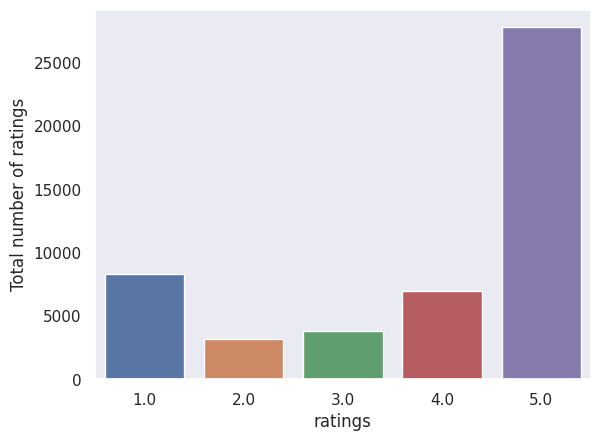

In [ ]:
sns.set(style='dark')
sns.countplot(x="ratings", data=electronics_df1)
plt.ylabel("Total number of ratings")
plt.show()
#Puanlama tablosu. (Rating table)

In [ ]:
# "Unique" kullanıcı sayısı
print('Number of unique users= ', electronics_df1['userId'].nunique())
# "Unique" ürün sayısı
print('Number of unique product = ', electronics_df1['productId'].nunique())

Number of unique users=  47298
Number of unique product =  1122


### Datayı daha yoğun hale getiriyorum ( Making the data denser )

In [ ]:
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users (ratings based): \n',most_rated)

Top 10 users (ratings based): 
 userId
A2E22B6U6A4NQK    61
A1O35FYKDTF5Z9    33
A2Y8D7OG18GERD    27
AAT47MLSLM5CQ     25
A3VZXF1X0XG9AU    20
A39ZUL4KR3DWX7    20
A1DXBKM7D2TEB1    17
A1XX3F6RMMFDL3    16
AGFQDHLM4TCWH     15
AIRGWQ6CU6DUD     13
dtype: int64


In [ ]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=25].index)]
print('No of users who have rated 25 or more =', len(electronics_df1_final)) #25 veya daha fazla üründe oy kullanmış kullanıcı sayısı.
print('No of unique users in the final data = ', electronics_df1_final['userId'].nunique()) # Verilerin son haline göre kalan "Unique" kullanıcı sayısı.
print('No of unique products in the final data = ', electronics_df1_final['userId'].nunique()) # Verilerin son haline göre kalan "Unique" ürün sayısı.

No of users who have rated 25 or more = 146
No of unique users in the final data =  4
No of unique products in the final data =  4


In [ ]:
electronics_df1_final = electronics_df1_final.drop_duplicates(subset=['userId', 'productId'])

In [ ]:
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
userId,,,,,,,,,,,,,,,,,,,,,
A1O35FYKDTF5Z9,3.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A2E22B6U6A4NQK,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2Y8D7OG18GERD,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0
AAT47MLSLM5CQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0


In [ ]:
print('Shape of final ratings matrix: ', final_ratings_matrix.shape)

Shape of final ratings matrix:  (4, 114)


In [ ]:
#Puanlama matrisinin yoğunluğunu hesaplıyorum. (Calucating the density of the rating matrix)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num of ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible num of ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num of ratings =  146
possible num of ratings =  456
density: 32.02%


### Verileri ayırıyorum (Splitting the data)

In [ ]:
#Test ve train verisetleri oluşturmak için datayı 75/25 oranında ayırıyorum. (Splitting the data randomly into train and test datasets into 75:25 ratio)
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.25, random_state=0)
train_data.head()

,productId,userId,ratings
523,B017OBNE6O,A1O35FYKDTF5Z9,3.0
20261,B01DE3FBN0,AAT47MLSLM5CQ,3.0
19290,B01B5BXC52,A2E22B6U6A4NQK,1.0
11494,B01DL0XYVW,AAT47MLSLM5CQ,3.0
19375,B01BH1URE4,A2E22B6U6A4NQK,5.0


In [ ]:
print('Shape of training data: ',train_data.shape) #train verisetinin shape i
print('Shape of testing data: ',test_data.shape) #test verisetinin shape i

Shape of training data:  (109, 3)
Shape of testing data:  (37, 3)


### Popülerliğe göre öneren model oluşturma. (Building Popularity Recommender model)

In [ ]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B017O9O8OS,1
1,B017OB648E,2
2,B017OBE2NI,1
3,B017OBEP6M,2
4,B017OBFKEI,1
5,B017OBHGZO,1
6,B017OBJI46,2
7,B017OBKT2Q,2
8,B017OBMC1M,1
9,B017OBN1FI,1


In [ ]:
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

#Top 5 öneri (top 5 recommendations)
pop_recommendations = train_data_sort.head(5)
pop_recommendations

,productId,score,rank
10,B017OBNE6O,3,1.0
11,B017OBNX7Y,3,2.0
1,B017OB648E,2,3.0
3,B017OBEP6M,2,4.0
6,B017OBJI46,2,5.0


In [ ]:
def recommend(user_id):
    user_recommendations = pop_recommendations
    user_recommendations['userId'] = user_id

    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [ ]:
find_recom = [2,25,86] #Öneri listesi (popülerliğe göre.)
for y in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(y))
    print("\n")

The list of recommendations for the userId: 86

    userId   productId  score  rank
10       2  B017OBNE6O      3   1.0
11       2  B017OBNX7Y      3   2.0
1        2  B017OB648E      2   3.0
3        2  B017OBEP6M      2   4.0
6        2  B017OBJI46      2   5.0


The list of recommendations for the userId: 86

    userId   productId  score  rank
10      25  B017OBNE6O      3   1.0
11      25  B017OBNX7Y      3   2.0
1       25  B017OB648E      2   3.0
3       25  B017OBEP6M      2   4.0
6       25  B017OBJI46      2   5.0


The list of recommendations for the userId: 86

    userId   productId  score  rank
10      86  B017OBNE6O      3   1.0
11      86  B017OBNX7Y      3   2.0
1       86  B017OB648E      2   3.0
3       86  B017OBEP6M      2   4.0
6       86  B017OBJI46      2   5.0




### Collaborative Filtrelemeli öneri modellemesi (Collaborative Filtering recommender model)

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,productId,userId,ratings
0,523,B017OBNE6O,A1O35FYKDTF5Z9,3.0
1,20261,B01DE3FBN0,AAT47MLSLM5CQ,3.0
2,19290,B01B5BXC52,A2E22B6U6A4NQK,1.0
3,11494,B01DL0XYVW,AAT47MLSLM5CQ,3.0
4,19375,B01BH1URE4,A2E22B6U6A4NQK,5.0


In [ ]:
# Her satır bir kullanıcıyı, her sütun da bir ürünü temsil etmektedir. ()
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
userId,,,,,,,,,,,,,,,,,,,,,
A1O35FYKDTF5Z9,3.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A2E22B6U6A4NQK,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2Y8D7OG18GERD,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0
AAT47MLSLM5CQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (4, 114)


In [ ]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO,user_index
user_index,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0,3


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
user_index,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0


### Tekil Değer Ayrışımı (Singular value decomposition)

In [ ]:
pivot_df_values = pivot_df.values
U, sigma, Vt = svds(pivot_df_values, k = 3)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.03128619 -0.87597143 -0.25087545]
 [ 0.15274579  0.27500134 -0.94905358]
 [ 0.07167807 -0.3940843  -0.12031049]
 [-0.98516605  0.04178372 -0.14793306]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [15.07161942 18.65666596 23.3317903 ]


In [ ]:
# TDA içinde çapraz dizi oluşturma (Construct diagonal array in SVD)
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[15.07161942  0.          0.        ]
 [ 0.         18.65666596  0.        ]
 [ 0.          0.         23.3317903 ]]


In [ ]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.0062275   0.00060416 -0.00830334  0.04920164 -0.0062275  -0.0062275
  -0.0062275  -0.00207583 -0.00830334 -0.00354751  0.00535999  0.01547581
  -0.00830334  0.01879765  0.00658715 -0.00354751  0.00060416 -0.00147167
  -0.1820551  -0.0062275  -0.0062275  -0.06536564  0.00268    -0.0062275
   0.00120832 -0.00415167  0.05335331  0.00060416 -0.00207583  0.01962748
   0.02377915  0.00475583  0.01013466  0.02026933  0.05542915  0.01489049
   0.01013466  0.01013466 -0.17582759  0.01902332  0.03040399  0.05542915
  -0.00207583  0.02026933  0.05067332  0.02026933 -0.29642421  0.05067332
   0.02026933  0.01013466  0.01013466  0.01013466  0.01013466  0.02026933
   0.01013466  0.04053865  0.01013466  0.00989015  0.03040399 -0.04509631
   0.01013466  0.01013466  0.01013466  0.05067332  0.05067332  0.05067332
   0.05067332 -0.24119323  0.02026933  0.01013466  0.01013466  0.01013466
  -0.12059662 -0.19609692  0.03040399  0.05067332  0.01013466 -0.01469232
  -0.13073128  

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
0,2.493730,2.035634,3.324973,2.828987,2.493730,2.493730,2.493730,0.831243,3.324973,3.698120,...,0.031334,0.156668,1.492588,1.865735,0.094001,4.156216,0.125334,0.373147,0.156668,0.373147
1,-0.022734,0.001600,-0.030312,4.992321,-0.022734,-0.022734,-0.022734,-0.007578,-0.030312,-0.013556,...,0.001407,0.007035,0.067024,0.083780,0.004221,-0.037890,0.005628,0.016756,0.007035,0.016756
2,1.119441,0.921209,1.492588,1.378135,1.119441,1.119441,1.119441,0.373147,1.492588,1.667503,...,-0.069283,-0.346416,0.699659,0.874574,-0.207850,1.865735,-0.277133,0.174915,-0.346416,0.174915
3,0.094001,-0.006616,0.125334,0.031752,0.094001,0.094001,0.094001,0.031334,0.125334,0.056051,...,0.994182,4.970911,-0.277133,-0.346416,2.982547,0.156668,3.976729,-0.069283,4.970911,-0.069283


In [ ]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    user_idx = userID-1
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\n Below are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 2
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B01EIQYF3E                  0.0          0.083780
B01E7TYGFO                  0.0          0.083780
B01CTJ1XY6                  0.0          0.083780
B017YBAFW0                  0.0          0.083780
B017YAF22Y                  0.0          0.068624


In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B01AVKAZ94                  0.0          0.159482
B01ED658W6                  0.0          0.156668
B01F4XQ5NS                  0.0          0.156668
B017OBE2NI                  0.0          0.125334
B017OBN1FI                  0.0          0.125334


### Collaborative recommendation model'in değerlendirmesi (assessment of Collaborative recommendation model)

In [ ]:
#Gerçek ratingler (Actual ratings)
final_ratings_matrix.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
userId,,,,,,,,,,,,,,,,,,,,,
A1O35FYKDTF5Z9,3.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
A2E22B6U6A4NQK,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2Y8D7OG18GERD,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0
AAT47MLSLM5CQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,0.0


In [ ]:
# Tahmini Ratingler (Predicted ratings )
preds_df.head()

productId,B017O9O8OS,B017OB648E,B017OBE2NI,B017OBEP6M,B017OBFKEI,B017OBGRKY,B017OBHGZO,B017OBI3AQ,B017OBIKIG,B017OBJI46,...,B01EFHVED0,B01EIFGQEG,B01EIQLWUS,B01EIQYF3E,B01EXOGWSM,B01F4XQ5NS,B01FPW5CNM,B01FV34BGE,B01GWCNPWE,B01H23V0RO
0,2.493730,2.035634,3.324973,2.828987,2.493730,2.493730,2.493730,0.831243,3.324973,3.698120,...,0.031334,0.156668,1.492588,1.865735,0.094001,4.156216,0.125334,0.373147,0.156668,0.373147
1,-0.022734,0.001600,-0.030312,4.992321,-0.022734,-0.022734,-0.022734,-0.007578,-0.030312,-0.013556,...,0.001407,0.007035,0.067024,0.083780,0.004221,-0.037890,0.005628,0.016756,0.007035,0.016756
2,1.119441,0.921209,1.492588,1.378135,1.119441,1.119441,1.119441,0.373147,1.492588,1.667503,...,-0.069283,-0.346416,0.699659,0.874574,-0.207850,1.865735,-0.277133,0.174915,-0.346416,0.174915
3,0.094001,-0.006616,0.125334,0.031752,0.094001,0.094001,0.094001,0.031334,0.125334,0.056051,...,0.994182,4.970911,-0.277133,-0.346416,2.982547,0.156668,3.976729,-0.069283,4.970911,-0.069283


In [ ]:
# Ürün için ortalama gerçek puanlama. (Avg rating for item)
final_ratings_matrix.mean().head()

productId
B017O9O8OS    0.75
B017OB648E    0.75
B017OBE2NI    1.00
B017OBEP6M    2.25
B017OBFKEI    0.75
dtype: float64

In [ ]:
# Ürün için tahmini puanlama (Avg predict rating for item)
preds_df.mean().head()

productId
B017O9O8OS    0.921109
B017OB648E    0.737957
B017OBE2NI    1.228146
B017OBEP6M    2.307799
B017OBFKEI    0.921109
dtype: float64

In [244]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(114, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item
productId,,,
B017O9O8OS,0.75,0.921109,0
B017OB648E,0.75,0.737957,1
B017OBE2NI,1.00,1.228146,2
B017OBEP6M,2.25,2.307799,3
B017OBFKEI,0.75,0.921109,4


In [252]:
#Ortalama Karekök Sapması (Root-mean-square deviation)
RMSE = round((((rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']) ** 2).mean() ** 0.5), 5)
print('\n RMSE SVD Model = {} \n'.format(RMSE))


 RMSE SVD Model = 0.17173 



In [257]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B01AVKAZ94                  0.0          0.159482
B01ED658W6                  0.0          0.156668
B01F4XQ5NS                  0.0          0.156668
B017OBE2NI                  0.0          0.125334
B017OBN1FI                  0.0          0.125334
